In [1]:
# just imports
%load_ext autoreload
%autoreload 2

import sys
import time

import torch
import torch.nn as nn
import torch.nn.functional as F

from torch.autograd import Variable
from torch.utils import data
from torch.optim import Adam

from torchvision import transforms
from torchvision import datasets

import numpy as np

from matplotlib import pyplot as plt
from pandas import read_fwf, DataFrame
from tqdm   import tqdm_notebook as tqdm
import matplotlib.gridspec as gridspec

from scipy.ndimage.interpolation import rotate
from sklearn.model_selection import train_test_split

In [2]:
# local imports
sys.path.append('../')
from VAE.rg_dataset import LRG, BasicDataset
from VAE.loss_funcs import VAE_Loss
from VAE import vae_models

In [3]:
%%time
data_path = '../data/'
aug=5

lrg_data_set   = LRG(use_kittler=True, n_aug=aug, blur=True, catalog_dir=data_path + 'catalog/mrt-table3.txt', 
                                                               file_dir=data_path + 'lrg')

unlrg_data_set = LRG(use_kittler=True, n_aug=aug, blur=True, catalog_dir=data_path + 'catalog/mrt-table4.txt',
                                                               file_dir=data_path + 'unlrg')

../data/lrg:	1442/1442
../data/unlrg:	14245/14245
CPU times: user 6min 29s, sys: 7min 4s, total: 13min 33s
Wall time: 4min 33s


In [4]:
batch_size = 16 #supposedly low batch size helps fater convergence

data_loader_lrg   = data.DataLoader(lrg_data_set,   batch_size=128, shuffle=False)
data_loader_unlrg = data.DataLoader(unlrg_data_set, batch_size=16,  shuffle=False)

sample = iter(data_loader_lrg).next()

In [5]:
class VAE(nn.Module):
    def __init__(self, lt_dim=4, k=None, batch_norm=True):
        super(VAE, self).__init__()
        self.k = k
        n_layers = len(self.k)
        encoder_layers = []
        decoder_layers = []
        
        for i in range( n_layers -1) :
            in_c, out_c = self.k[i], self.k[i + 1]
            if(in_c == 'M'): continue
            stride = 1
            if out_c == 'M':
                stride = 2
                i += 1
                out_c = self.k[i + 1]
            layer = nn.Conv2d(in_c, out_c, kernel_size=3, padding=1, stride=stride)
            encoder_layers.append(layer)
            if batch_norm:
                encoder_layers.append(nn.BatchNorm2d(out_c))
            encoder_layers.append(nn.ReLU(inplace=True))
        self.encoder = nn.Sequential(*encoder_layers)
        
        for i in range(n_layers - 1, 0, -1):
            in_c, out_c = self.k[i], self.k[i - 1]
            if(in_c == 'M'): continue
            stride = 1
            output_padding=0
            if out_c == 'M':
                stride = 2
                i -= 1
                out_c = self.k[i - 1]
                output_padding=1
                
            layer = nn.ConvTranspose2d(in_c, out_c, kernel_size=3, padding=1, 
                                       output_padding=output_padding, stride=stride)
            decoder_layers.append(layer)
            if batch_norm:
                decoder_layers.append(nn.BatchNorm2d(out_c))
            decoder_layers.append(nn.ReLU(inplace=True))

        self.decoder = nn.Sequential(*decoder_layers[:-1])
        
        self.fc_mu = nn.Sequential(
                      nn.Linear(self.k[-1]*2*2, lt_dim*2),
                      nn.Linear(lt_dim*2, lt_dim)
        )
        self.fc_ep = nn.Sequential(
                      nn.Linear(self.k[-1]*2*2, lt_dim*2),
                      nn.Linear(lt_dim*2, lt_dim)
        )
        
        self.fc_dc = nn.Linear(lt_dim, self.k[-1]*2*2)
        
    def encode(self, x):
        encoded = self.encoder(x)
        encoded = encoded.view(-1, self.k[-1]*2*2)
        return self.fc_mu(encoded), self.fc_ep(encoded)
    
    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5*logvar)
        eps = torch.randn_like(std)
        if self.training :
            return mu + eps*std
        return mu

    def decode(self, x):
        x = F.relu(self.fc_dc(x))
        x = x.view(-1, self.k[-1], 2, 2) #reshape
        return torch.sigmoid(self.decoder(x))
    
    def forward(self, x):
        mu, var = self.encode(x)
        z = self.reparameterize(mu, var)
        d = self.decode(z)
        return d, mu, var

In [32]:
def train_step_vae(mode, device, data_loader, optim, epoch, loss_fun, log_interval=5, beta=1):
    model.train()
    s = ''
    r_loss = 0
    batch_sum = 0
    avg_r_loss = 0
    for batch_idx, (data, target) in enumerate(data_loader):
        batch_sum += len(data)
        data = data.to(device)
        target = Variable(data, requires_grad=False).to(device)
        #Forward Pass
        optim.zero_grad()
        output = model(data)

        # BCE Loss
        r_loss, g_loss = loss_fun(output, data)
        loss = r_loss + (beta * g_loss)
        avg_r_loss += r_loss.item()
        #Backpropagation
        loss.backward()
        optim.step()
        s = 'Train Epoch: {:3d} [{:5d}/{:5d} ({:3.0f}%)]\tLoss: {:4.4f}\tR_Loss: {:4.4f}\tDKL: {:4.4f}'
        s = s.format(epoch, batch_sum, len(data_loader.dataset),
                100. * batch_idx / len(data_loader), loss.item()/len(data),
                     r_loss.item()/len(data), g_loss.item()/len(data))
        
        if batch_idx % log_interval == 0:
            sys.stdout.write('{}\r'.format(s))
            sys.stdout.flush()
    return s, avg_r_loss / batch_sum

In [33]:
def test_step_vae(model, device, data_loader, loss_fun, learn_rot=False):
    model.eval()
    avg_r_loss = 0
    batch_sum = 0 
    for batch_idx, (data, target) in enumerate(data_loader):
        batch_sum += len(data)
        with torch.no_grad():
            data = data.to(device)
            #Forward Pass
            output = model(data)
            # BCE Loss
            r_loss , g_loss = loss_fun(output, data)
            avg_r_loss += r_loss.item()
            
    return avg_r_loss / batch_sum

In [34]:
device = 'cuda'
epochs = 40

Train Epoch:   1 [69900/69900 (100%)]	Loss: 58.6662	R_Loss: 58.5744	DKL: 0.0919	AvgR 91.7193	Test Loss : 5.1924   Time : 142.43s
Train Epoch:   2 [69900/69900 (100%)]	Loss: 19.6554	R_Loss: 19.4529	DKL: 0.2025	AvgR 23.3153	Test Loss : 1.6689   Time : 145.57s
Train Epoch:   3 [69900/69900 (100%)]	Loss: 12.0284	R_Loss: 11.9267	DKL: 0.1017	AvgR 7.8568	Test Loss : 0.9445   Time : 146.24s
Train Epoch:   4 [69900/69900 (100%)]	Loss: 11.0142	R_Loss: 10.8722	DKL: 0.1420	AvgR 4.1089	Test Loss : 0.7067   Time : 148.21s
Train Epoch:   5 [69900/69900 (100%)]	Loss: 10.7085	R_Loss: 10.5071	DKL: 0.2014	AvgR 3.0583	Test Loss : 0.5776   Time : 150.77s
Train Epoch:   6 [69900/69900 (100%)]	Loss: 8.1913	R_Loss: 7.6865	DKL: 0.5048	AvgR 2.5258	Test Loss : 0.4986   Time : 139.96s
Train Epoch:   7 [69900/69900 (100%)]	Loss: 7.8510	R_Loss: 7.2984	DKL: 0.5526	AvgR 2.3205	Test Loss : 0.4721   Time : 134.38s
Train Epoch:   8 [69900/69900 (100%)]	Loss: 7.7806	R_Loss: 7.1781	DKL: 0.6026	AvgR 2.2573	Test Loss : 0.46

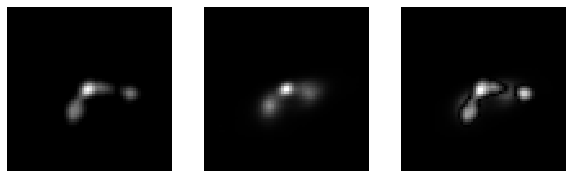

Train Epoch:  11 [69900/69900 (100%)]	Loss: 7.0336	R_Loss: 6.4530	DKL: 0.5806	AvgR 2.1868	Test Loss : 0.4815   Time : 134.68s
Train Epoch:  12 [69900/69900 (100%)]	Loss: 7.1271	R_Loss: 6.5266	DKL: 0.6005	AvgR 2.1716	Test Loss : 0.4564   Time : 135.63s
Train Epoch:  13 [69900/69900 (100%)]	Loss: 6.9536	R_Loss: 6.3529	DKL: 0.6007	AvgR 2.1610	Test Loss : 0.4536   Time : 134.70s
Train Epoch:  14 [69900/69900 (100%)]	Loss: 6.8438	R_Loss: 6.2712	DKL: 0.5725	AvgR 2.1548	Test Loss : 0.4540   Time : 135.79s
Train Epoch:  15 [69900/69900 (100%)]	Loss: 7.4085	R_Loss: 6.8052	DKL: 0.6033	AvgR 2.1463	Test Loss : 0.4547   Time : 137.28s
Train Epoch:  16 [69900/69900 (100%)]	Loss: 6.9067	R_Loss: 6.3104	DKL: 0.5963	AvgR 2.1401	Test Loss : 0.4498   Time : 136.67s
Train Epoch:  17 [69900/69900 (100%)]	Loss: 6.8090	R_Loss: 6.2240	DKL: 0.5850	AvgR 2.1355	Test Loss : 0.4594   Time : 135.71s
Train Epoch:  18 [69900/69900 (100%)]	Loss: 6.7731	R_Loss: 6.1820	DKL: 0.5911	AvgR 2.1336	Test Loss : 0.4512   Time : 

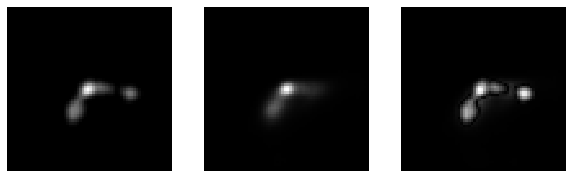

Train Epoch:  21 [69900/69900 (100%)]	Loss: 6.8314	R_Loss: 6.2327	DKL: 0.5987	AvgR 2.1200	Test Loss : 0.4605   Time : 136.87s
Train Epoch:  22 [69900/69900 (100%)]	Loss: 6.8340	R_Loss: 6.2477	DKL: 0.5863	AvgR 2.1149	Test Loss : 0.4544   Time : 136.93s
Train Epoch:  23 [69900/69900 (100%)]	Loss: 7.1701	R_Loss: 6.5403	DKL: 0.6297	AvgR 2.1101	Test Loss : 0.4501   Time : 135.87s
Train Epoch:  24 [69900/69900 (100%)]	Loss: 7.2908	R_Loss: 6.7253	DKL: 0.5655	AvgR 2.1047	Test Loss : 0.4620   Time : 135.24s
Train Epoch:  25 [69900/69900 (100%)]	Loss: 7.0017	R_Loss: 6.3835	DKL: 0.6182	AvgR 2.1010	Test Loss : 0.4569   Time : 136.67s
Train Epoch:  26 [69900/69900 (100%)]	Loss: 6.9499	R_Loss: 6.3045	DKL: 0.6454	AvgR 2.0979	Test Loss : 0.4409   Time : 134.27s
Train Epoch:  27 [69900/69900 (100%)]	Loss: 6.8875	R_Loss: 6.3243	DKL: 0.5632	AvgR 2.0950	Test Loss : 0.4511   Time : 136.79s
Train Epoch:  28 [69900/69900 (100%)]	Loss: 6.6896	R_Loss: 6.0503	DKL: 0.6393	AvgR 2.0920	Test Loss : 0.4488   Time : 

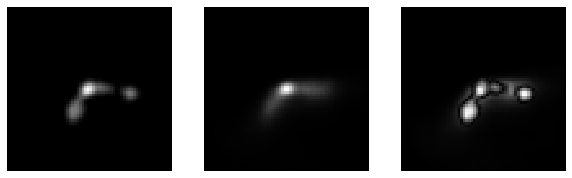

Train Epoch:  31 [69900/69900 (100%)]	Loss: 6.7531	R_Loss: 6.1663	DKL: 0.5868	AvgR 2.0876	Test Loss : 0.4538   Time : 135.46s
Train Epoch:  32 [69900/69900 (100%)]	Loss: 6.9435	R_Loss: 6.2959	DKL: 0.6476	AvgR 2.0869	Test Loss : 0.4537   Time : 134.04s
Train Epoch:  33 [69900/69900 (100%)]	Loss: 6.7519	R_Loss: 6.1139	DKL: 0.6380	AvgR 2.0846	Test Loss : 0.4777   Time : 134.31s
Train Epoch:  34 [69900/69900 (100%)]	Loss: 6.9880	R_Loss: 6.3912	DKL: 0.5967	AvgR 2.0838	Test Loss : 0.4543   Time : 135.97s
Train Epoch:  35 [69900/69900 (100%)]	Loss: 6.8936	R_Loss: 6.2524	DKL: 0.6412	AvgR 2.0831	Test Loss : 0.4705   Time : 136.57s
Train Epoch:  36 [69900/69900 (100%)]	Loss: 6.8103	R_Loss: 6.1928	DKL: 0.6175	AvgR 2.0795	Test Loss : 0.4453   Time : 137.22s
Train Epoch:  37 [69900/69900 (100%)]	Loss: 7.0199	R_Loss: 6.4072	DKL: 0.6127	AvgR 2.0799	Test Loss : 0.4442   Time : 136.73s
Train Epoch:  38 [69900/69900 (100%)]	Loss: 7.0694	R_Loss: 6.4353	DKL: 0.6341	AvgR 2.0792	Test Loss : 0.4497   Time : 

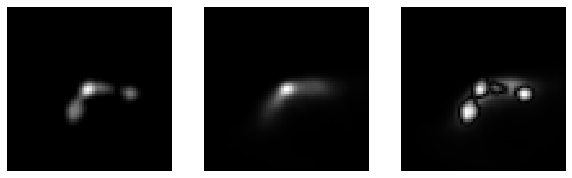

In [35]:
k = [1, 16, 'M', 32, 'M', 64, 64,'M', 64, 'M', 128, 128, 'M', 256]
model = VAE(lt_dim=8, k=k).to(device)
# model = vae_models.VAE().to(device)
optimizer = Adam(model.parameters(), lr=0.0005, weight_decay=1E-5)
loss_fun = VAE_Loss()

train_loss = []
test_loss  = []
for epoch in range(1, epochs+1):
    #LRG, forced params
    start = time.time()
    s, l = train_step_vae(model, device, data_loader_unlrg, optimizer, epoch, loss_fun=loss_fun)
    loss = test_step_vae(model, device, data_loader_lrg, loss_fun=loss_fun)
    
    train_loss.append(l)
    test_loss.append(loss)
    t = time.time() - start
    
    sys.stdout.write('{}\tAvgR {:.4f}\tTest Loss : {:4.4f}   Time : {:.2f}s\n'.format(s, l, loss, t))
    if epoch % 10 == 0: 
        f, ax = plt.subplots(1, 3, figsize=(10, 5))
        o = model(sample[0].to(device))
        ax[0].imshow(sample[0][1][0], cmap='gray')
        ax[1].imshow(o[0][1][0].detach().cpu(), cmap='gray')
        diff = sample[0][1][0] - o[0][1][0].detach().cpu()
        ax[2].imshow(np.abs(diff), cmap='gray')
        ax[0].axis('off')
        ax[1].axis('off')
        ax[2].axis('off')
        plt.show()

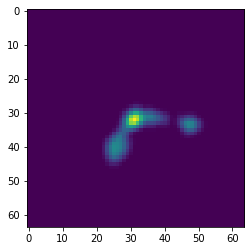

In [10]:
i = 1
plt.imshow(sample[0][i][0])

In [59]:
o = model(sample[0].to(device))

In [60]:
# o.shape

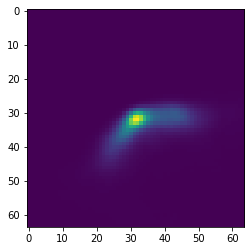

In [61]:
plt.imshow(o[0][i][0].detach().cpu())

In [14]:
torch.save(model, 'SimpleVAE')

In [44]:
s = sample[0][i:i+1]

In [78]:
with torch.no_grad():
    e = model.encode(s.to(device))[0]

In [68]:
with torch.no_grad():
    d = model.decode(e)

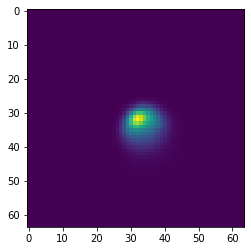

In [69]:
plt.imshow(d[0][0].cpu())

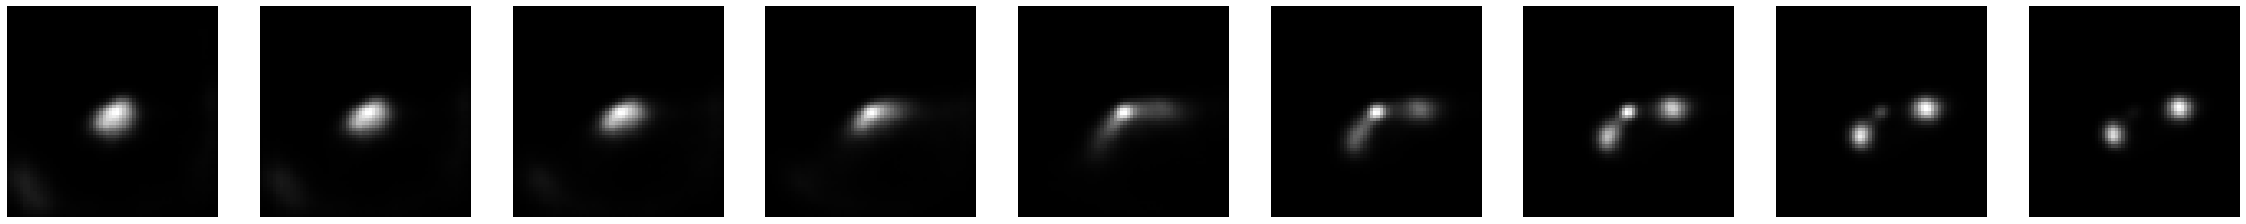

In [130]:
f, ax = plt.subplots(1, 9, figsize=(40, 20))

j = 7
for k, i in enumerate(np.arange(-2, 2.5, .5)):
    b = torch.tensor(e)
    b[0][j] = e[0][j] + 2*i
    with torch.no_grad():
        d = model.decode(b).cpu()[0][0]
    ax[k].imshow(d, cmap='gray')
    ax[k].axis('off')

In [127]:
e[0][6]

tensor(-0.0478, device='cuda:0')

In [80]:
b = torch.tensor(e)

In [83]:
b[0][0] = 0

In [115]:
np.arange(-4, 4.5, 1)

array([-4., -3., -2., -1.,  0.,  1.,  2.,  3.,  4.])